In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import keras
import ast
import re
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
import pandas as pd
from scipy import ndimage
import ast
import operator as op

# utils

In [3]:
def image_resize(image,width = None,height = None,inter = cv2.INTER_LINEAR):
    dim = None
    (h,w) = image.shape[:2]
    
    if width is None and height is None:
        return image
    
    if width is None:
        r = height / float(h)
        dim = (int(w*r),height)
    else:
        r = width/float(w)
        dim = (width,int(h*r))
    print
    resized = cv2.resize(image,dim,interpolation=inter)
    return resized

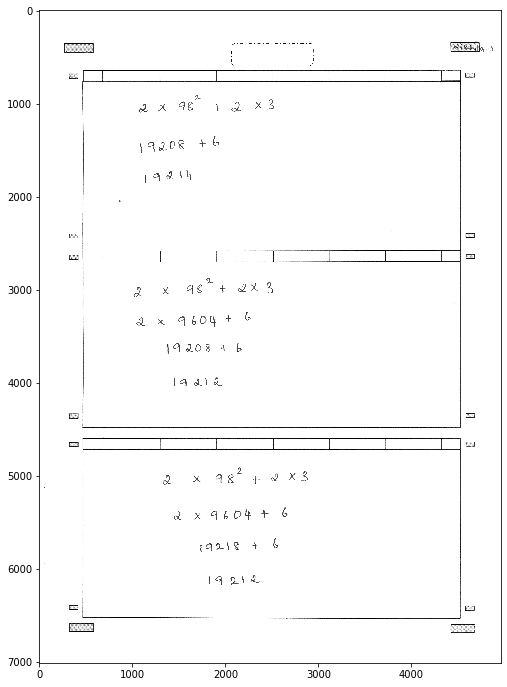

In [4]:
img = cv2.imread('D:/projects/digit recognizer + solver/image_13.JPG')
img = image_resize(img)
figure = plt.figure(figsize=(12,12))
plt.imshow(img)
A = 2
B = 2
X = 98
Y = 3

In [5]:
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [6]:
thresh,binary_image = cv2.threshold(img_gray,250,255,cv2.THRESH_BINARY_INV)

In [7]:
kernel_length = np.array(binary_image).shape[1]//50
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(1,kernel_length))
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(kernel_length,1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

In [8]:
img_temp1 = cv2.erode(binary_image,verticle_kernel,iterations=3)
verticle_lines_img = cv2.dilate(img_temp1,verticle_kernel,iterations=3)

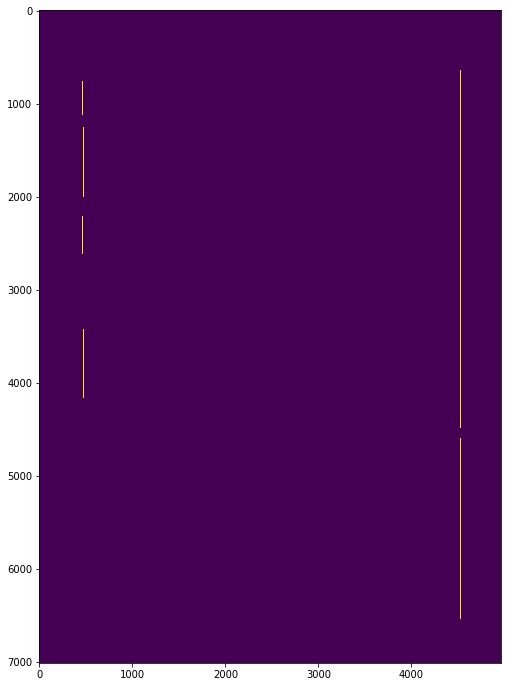

In [9]:
figure = plt.figure(figsize=(12,12))
plt.imshow(verticle_lines_img)


In [10]:
img_temp2 = cv2.erode(binary_image,hori_kernel,iterations=3)
horizontal_lines_img = cv2.dilate(img_temp2,hori_kernel,iterations=3)


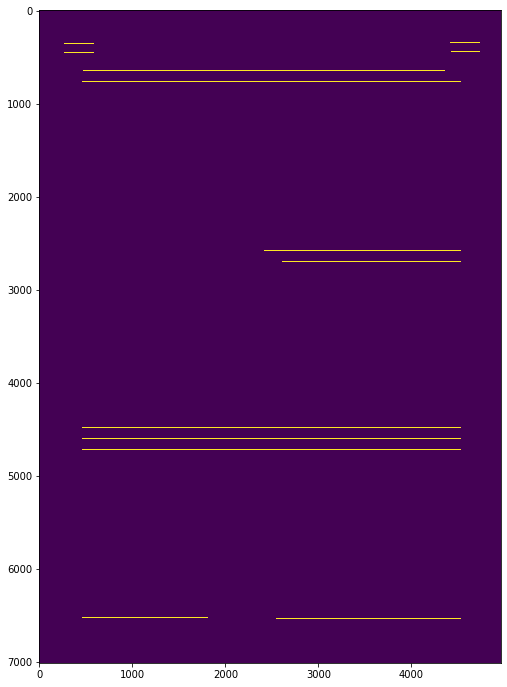

In [11]:
figure = plt.figure(figsize=(12,12))
plt.imshow(horizontal_lines_img)


In [12]:
alpha = 0.5

beta = 1.0-alpha

img_final = cv2.addWeighted(verticle_lines_img,alpha,horizontal_lines_img,beta,0.0)

img_final = cv2.erode(~img_final,kernel,iterations=2)

threshold,img_final = cv2.threshold(img_final,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

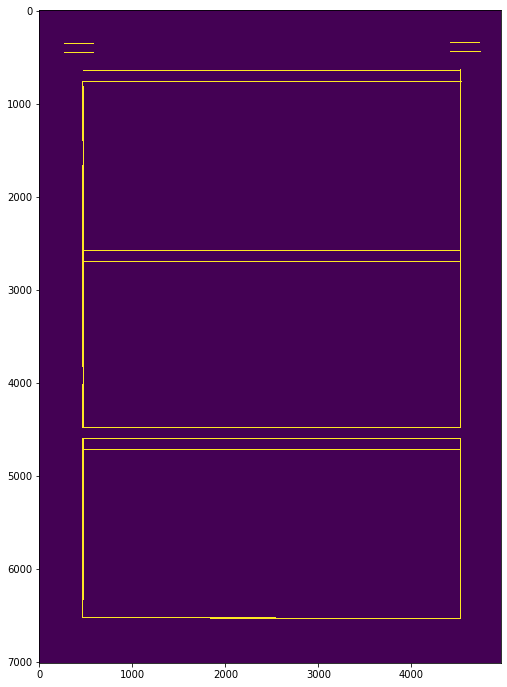

In [13]:
figure = plt.figure(figsize=(12,12))
plt.imshow(img_final)


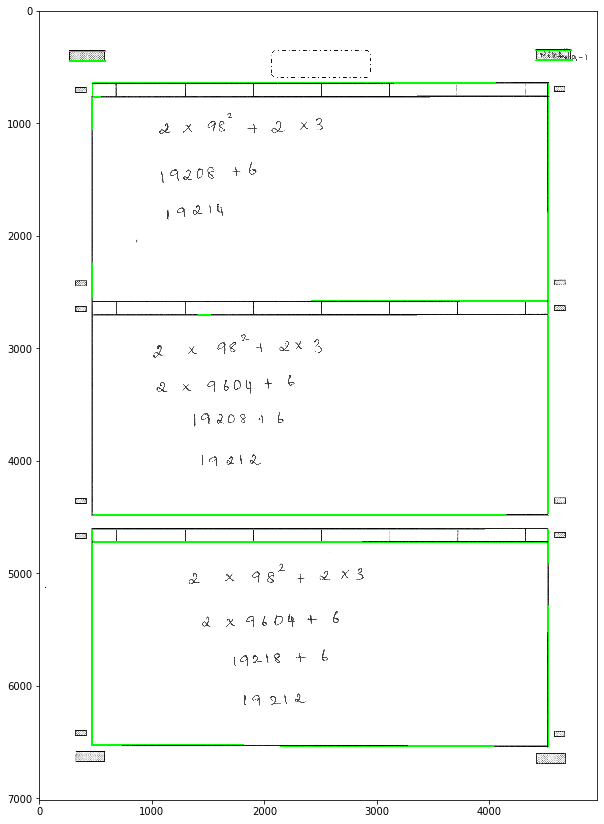

In [14]:
contours,hierarchy = cv2.findContours(img_final,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img,contours,-1,(0,255,0),3)
plt.figure(figsize=(10,30))
plt.imshow(img)

In [15]:
def sort_contours(cnts,method='left-to-right'):
    '''
    sort_contours : Function to sort contours
    argument:
    cnts(array) : image contours
    
    method(string) : sorting direction
    
    output:
    cnts(list):sorted contours
    boundingBoxes(list):bounding boxes
    
    '''
    #initialize the reverse flag and sort index
    reverse = False
    i = 0
    
    if method == 'right-to-left':
        reverse = True
    bounding_boxes = [cv2.boundingRect(c) for c in cnts]
    (cnts,boundingBoxes) = zip(*sorted(zip(cnts,bounding_boxes),key=lambda b:b[1][i]))
    return (cnts,bounding_boxes)

In [16]:
(contours,bounding_boxes) = sort_contours(contours)

In [17]:
def sort_contour(contours,bounding_boxes):
    area = []
    
    for con in contours:
        area.append(cv2.contourArea(con))
    s = np.argsort(area)
    main_contour =[]
    
    for i,con in enumerate(contours):
        if cv2.contourArea(con) >= area[s[-1]]*0.40 and  cv2.contourArea(con)<=area[s[-1]]*50:
            main_contour.append(con)
    main_recs =[]
    for cnt in main_contour:
        x,y,w,h = cv2.boundingRect(cnt)
        main_recs.append([x,y,w,h])

    return main_recs
    

In [18]:
main = sort_contour(contours,bounding_boxes)

In [19]:
print(len(main))

5


In [20]:
main = main[-3:]

In [21]:
def display_boxes(rects):
    fig = plt.figure(figsize=(10,12))
    i=1
    for rect in rects:
        ax =fig.add_subplot(len(rects),1,i)
        ax.imshow(img[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]])
        i+=1
    plt.show()

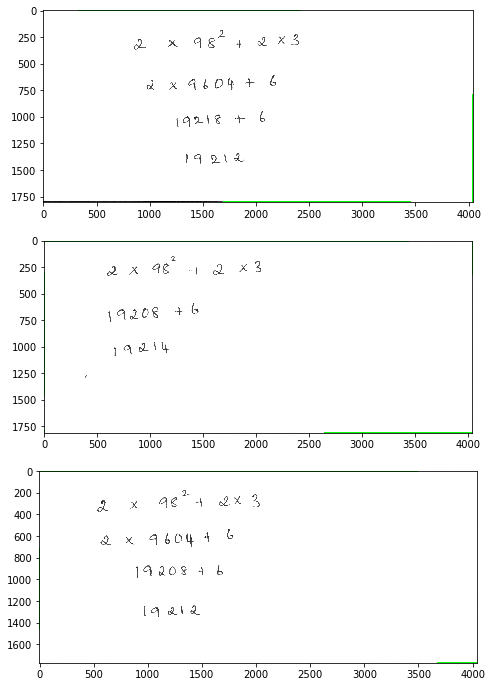

In [22]:
display_boxes(main)

In [23]:
def find_good_contours_thres(conts,alpha=0.002):
    '''
    to find the threshold of good contours
    on the basis of 10% of area
    '''
    areas = []
    
    for cont in conts:
        areas.append(cv2.contourArea(cont)**2)
    thres = alpha * max(areas)
    return thres
    

In [24]:
# # img_1 = img.copy()
# img_1 = img.copy()
# H,W = img_1.shape[:2]
# h5 = int(.02 * H)
# w5 = int(.02 * W)
# img_1[:h5,:] = [255,255,255]
# img_1[-h5:,:] = [255,255,255]
# img_1[:,:w5] = [255,255,255]
# img_1[:,-w5:] = [255,255,255]
# plt.imshow(img_1)

In [25]:
def extract_line(image,beta=0.7,alpha=0.002,show = True):
    img = image.copy()
    H,W = img.shape[:2]
    h5 = int(.02 * H)
    w5 = int(.02* W)
    img[:h5,:] = [255,255,255]
    img[-h5:,:] = [255,255,255]
    img[:,:w5] = [255,255,255]
    img[:,-w5:] = [255,255,255]
    #converting image to gray 
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    th,threshed = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(threshed,kernel,iterations=1)
    
    temp = dilation.copy()
    
    contours,hierarchy = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cont_thresh = find_good_contours_thres(contours,alpha=alpha)
    
    mask = np.ones(dilation.shape[:2],dtype='uint8')*255
    
    for c in contours:
        if (cv2.contourArea(c) **2 <cont_thresh):
            cv2.drawContours(mask,[c],-1,0,-1)
    cleaned_img = cv2.bitwise_and(temp,temp,mask=mask)
    
    #dialating the cleaned image for better detection of line in cases where
    #exponents are little up the line
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dil_cleaned_img = cv2.dilate(cleaned_img,kernel,iterations = 10)
    
    #getting back the cleaned original image without noise 
    cleaned_orig = cv2.erode(cleaned_img,kernel,iterations=1)
    
    #find and draw the upper and lower boundary of each lines 
    hist = cv2.reduce(dil_cleaned_img,1,cv2.REDUCE_AVG).reshape(-1)
    
    th=1
    H,W = img.shape[:2]
    
    uppers = np.array([y for y in range(H-1) if hist[y]<=th and hist[y+1]>th])
    
    lowers = np.array([y for y in range(H-1) if hist[y]>th and hist[y+1]<=th])
    
    diff_1 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_1 = np.array([True if j>beta*(np.mean(diff_1)-np.std(diff_1))else False for j in diff_1])
    uppers = uppers[diff_index_1]
    lowers = lowers[diff_index_1]
    
    #extending uppers and lowers indexes to avoid cutting of chars of lines
    #extended more uppers by 33% as exponential might lie above
    
    uppers[1:] = [i-int(j)/3 for i,j in zip(uppers[1:],diff_1[1:])]
    lowers[:-1] = [i+int(j)/4 for i,j in zip(lowers[:-1],diff_1[:-1])]
    
    diff_2 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_2 = np.array([True]*len(uppers))
    
    #combining the rouge exponentials into their deserving lines this happens when 
    #exponential and lines are seperated by some distance
    
    for i,diff in enumerate(diff_2):
        if(i>0):
            if((diff_2[i-1]<(diff/2)) and (lowers[i-1]-uppers[i])>((lowers[i-1]-uppers[i-1])/5)):
                uppers[i] = uppers[i-1]
                diff_2[i] = diff_2[i] + diff_2[i-1]
                diff_index_2[i-1] = False
                print('Merging')
    diff_index = diff_index_2
    
    cleaned_orig_rec = cv2.cvtColor(cleaned_orig,cv2.COLOR_GRAY2BGR)
    
    col_ct = 0 
    
    for left,right in zip(uppers[diff_index],lowers[diff_index]):
        
        col1 = (153,255,255)
        col2= (255,255,153)
        if (col_ct % 2 == 0):
            col = col1
        else:
            col = col2
        cv2.rectangle(cleaned_orig_rec,(0+10,left),(W-15,right),col,4)
        col_ct +=1
        
    if show == True:
        fig0 = plt.figure(figsize=(15,5))
        ax1 = fig0.add_subplot(1,3,1)
        ax1.set_title('original Image')
        ax1.imshow(img)
        ax1.axis('off')
        
        ax2 = fig0.add_subplot(1,3,2)
        ax2.set_title('Cleaned Image')
        ax2.imshow(cv2.cvtColor(cleaned_img,cv2.COLOR_GRAY2RGB))
        ax2.axis('off')
        
        ax3 = fig0.add_subplot(1,3,3)
        ax3.set_title('Noises')
        ax3.imshow(cv2.cvtColor(mask,cv2.COLOR_BGR2RGB))
        ax3.axis('off')
        
        fig0.suptitle('Denoising')
        plt.show()
        
        fig1 = plt.figure(figsize=(15,5))
        fig1.suptitle('Line Detection')
        ax1 = fig1.add_subplot(1,2,1)
        ax1.axis('off')
        ax1.imshow(cv2.cvtColor(cleaned_orig,cv2.COLOR_BGR2RGB))
        
        ax2 = fig1.add_subplot(1,2,2)
        ax2.axis('off')
        ax2.imshow(cv2.cvtColor(cleaned_orig_rec,cv2.COLOR_BGR2RGB))
        plt.show()
    return cleaned_orig,uppers[diff_index],lowers[diff_index]

In [26]:
def extract_line(image, beta=0.7, alpha=0.002, show = True):
    '''
    Function to extracts the line from the image   
    Assumption : Sufficient gap b/w lines
    
    argument:
        img (array): image array
        beta (0-1) : Parameter to differentiate line
        alpha (0-1) : Parameter to select good contours
        show(bool) : to show figures or not
    output:
        uppers[diff_index]  : Upper points (x,y)
        lowers[diff_index]  : lower points(x,y)
    '''
    img = image.copy()
    H,W = img.shape[:2]
    h5 = int(.02 * H)
    w5 = int(.02 * W)
    img[:h5,:] = [255,255,255]
    img[-h5:,:] = [255,255,255]
    img[:,:w5] = [255,255,255]
    img[:,-w5:] = [255,255,255]
    
    #Converting image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Binary thresholding and inverting at 127
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    
    #Selecting elliptical element for dilation    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(threshed,kernel,iterations = 1)
    
    #Saving a copy of dilated image for taking bitwise_and operation
    temp = dilation.copy()
    
    # Find the contours
    if(cv2.__version__ == '3.3.1'): 
        xyz,contours,hierarchy = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours,hierarchy = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    cont_thresh = find_good_contours_thres(contours, alpha=alpha)

    #Creating a mask of only ones    
    mask = np.ones(dilation.shape[:2], dtype="uint8") * 255

    #Drawing those contours which are noises and then taking bitwise and
    for c in contours:
        if( cv2.contourArea(c)**2 < cont_thresh):
            cv2.drawContours(mask, [c], -1, 0, -1)
    
    cleaned_img = cv2.bitwise_and(temp, temp, mask=mask)
    
    #Dilating the cleaned image for better detection of line in cases where
    #exponents are little up the line
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dil_cleaned_img = cv2.dilate(cleaned_img,kernel,iterations = 10)
    
    #Getting back the cleaned original image without noise
    cleaned_orig = cv2.erode(cleaned_img, kernel, iterations=1) 
    
    ##find and draw the upper and lower boundary of each lines
    hist = cv2.reduce(dil_cleaned_img,1, cv2.REDUCE_AVG).reshape(-1)
    
    th = 1
    H,W = img.shape[:2]
    uppers = np.array([y for y in range(H-1) if hist[y]<=th and hist[y+1]>th])
    lowers = np.array([y for y in range(H-1) if hist[y]>th and hist[y+1]<=th])
    
    diff_1 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_1 = np.array([True if j > beta*(np.mean(diff_1)-np.std(diff_1)) else False for j in diff_1 ])
    
    uppers = uppers[diff_index_1]
    lowers = lowers[diff_index_1]
    
    #Extending uppers and lowers indexes to avoid cutting of chars of lines
    #Extended more uppers by 33% as exponential might lie above 
    uppers[1:] = [i-int(j)/3 for i,j in zip(uppers[1:], diff_1[1:])]
    lowers[:-1] = [i+int(j)/4 for i,j in zip(lowers[:-1], diff_1[:-1])]
    
    diff_2 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_2 = np.array([True]*len(uppers))
    
    #Combining rogue exponentials into their deserving lines. This happens when
    #exponential and lines are separated by some distance
    for i,diff in enumerate(diff_2):
        if(i>0):
            if( (diff_2[i-1] < (diff/2)) and (( lowers[i-1]-uppers[i]) > ((lowers[i-1]-uppers[i-1])/5)) ):
                uppers[i] = uppers[i-1]
                diff_2[i] = diff_2[i]+diff_2[i-1]
                diff_index_2[i-1] = False
                print('Merging')

    diff_index = diff_index_2
    
    cleaned_orig_rec = cv2.cvtColor(cleaned_orig, cv2.COLOR_GRAY2BGR)
    
    #For changing color of intermediate lines, keeping count
    col_ct = 0
    
    for left,right in zip(uppers[diff_index], lowers[diff_index]):
        #print(left,right)
        col1 = (153,255,255)
        col2 = (255,255,153)
        if(col_ct % 2 == 0):
            col= col1
        else: 
            col=col2
        cv2.rectangle(cleaned_orig_rec ,(0+10,left),(W-15,right),col,4)
        col_ct += 1
        
    if(show == True):
        fig0 = plt.figure(figsize=(15,5))
        ax1 = fig0.add_subplot(1,3,1)
        ax1.set_title('Original Image')
        ax1.imshow(img)
        ax1.axis('off')
        
        ax2 = fig0.add_subplot(1,3,2)
        ax2.set_title('Cleaned Image')
        ax2.imshow(cv2.cvtColor(cleaned_img, cv2.COLOR_GRAY2RGB))
        ax2.axis('off')
        
        ax3 = fig0.add_subplot(1,3,3)
        ax3.set_title('Noises')
        ax3.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
        ax3.axis('off')
        
        fig0.suptitle('Denoising')
        plt.show()
    
        fig1 = plt.figure(figsize=(15,5))
        fig1.suptitle('Line Detection')
        ax1 = fig1.add_subplot(1,2,1)
        ax1.axis("off")
        ax1.imshow(cv2.cvtColor(cleaned_orig,cv2.COLOR_BGR2RGB))
        
        ax2 = fig1.add_subplot(1,2,2)    
        ax2.axis("off")
        ax2.imshow(cv2.cvtColor(cleaned_orig_rec, cv2.COLOR_BGR2RGB))
        
        plt.show()
    
    return cleaned_orig, uppers[diff_index], lowers[diff_index]

In [27]:
#loading the model
dict_clean_img = {} #BINARY IMAGE DICTIONAY
dict_img = {} #ORIGINAL IMAGE DICTIONARY
keras.backend.set_image_data_format('channels_first')

try:
    model = keras.models.load_model('OCR.h5',compile=False)
    
    model_robusta = keras.models.load_model('OCR.h5',compile=False)
except:
    print('Failed to load the model')

In [28]:
dict_clean_img


{}

# Load the model


In [29]:
def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted
def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)
    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)
    
    
    return shiftx,shifty
operators = {ast.Add: op.add, ast.Sub: op.sub, ast.Mult: op.mul,
             ast.Div: op.truediv, ast.Pow: op.pow, ast.BitXor: op.xor,
             ast.USub: op.neg}

In [30]:
#Data Generator using tensorflow method
train_datagen = ImageDataGenerator(   
    data_format='channels_first',
    zca_whitening = True,
    rotation_range = 0.2)

def predict(img,x1,y1,x2,y2,proba = False,acc_thresh = 0.60):
    '''
    predicts char positions
    '''
    
    gray = img[y1:y2,x1:x2]
    
    #steps to remove noises in image ddue to cropping 
    temp = gray.copy()
    
    kernel_temp = np.ones((3,3),np.uint8)
    temp_tmp = cv2.dilate(temp,kernel_temp,iterations=3)
    
    contours_tmp,hierarchy = cv2.findContours(temp_tmp,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours_tmp)>1:
        contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        mask = np.ones(gray.shape[:2],dtype = 'uint8')*0
        
        areas = [cv2.contourArea(c) for c in contours]
        max_index = np.argmax(areas)
        cnt = contours[max_index]
        
        cv2.drawContours(mask,[cnt],-1,255,-1)
        
        gray = cv2.bitwise_and(temp,temp,mask=mask)
    grayN = process_img(gray,resize_flag=0)
    
    classes = model.predict(grayN,batch_size=2)
    ind = np.argmax(classes)
    c= ['0','1','2','3','4','5','6','7','8','9','+','-','*','(',')']
    if(c[ind]=='5'or c[ind] =='6'):
        grayN_1 = process_img(gray,resize_flag = 1)
        classes = model.predict(grayN_1,batch_size=2)
        ind = np.argmax(classes)
        if(proba == True):
            return classes[0][ind]
        return c[ind]
    if(classes[0][ind]< acc_thresh):
        grayN_2 = process_img(gray,resize_flag=1,preproc=1)
        
        imgs = train_datagen.flow(grayN_2,batch_size=10)
        yhats = model_robusta.predict_generator(imgs,steps=10,verbose=0)
        yhats = np.mean(yhats,axis=0)
        yhats = yhats[:,None].reshape(1,15)
        ind = np.argmax(classes)
        
        if(proba==True):
            return classes[0][ind]
        return c[ind]
    if (proba==True):
        return classes[0][ind]
    return c[ind]

C:\Users\naray\Anaconda3\envs\mirai_1\lib\site-packages\keras_preprocessing\image\image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [31]:
def eval_(node):
    if isinstance(node, ast.Num): # <number>
        return node.n
    elif isinstance(node, ast.BinOp): # <left> <operator> <right>
        return operators[type(node.op)](eval_(node.left), eval_(node.right))
    elif isinstance(node, ast.UnaryOp): # <operator> <operand> e.g., -1
        return operators[type(node.op)](eval_(node.operand))
    else:
        raise TypeError(node)


In [48]:
def evaluate(df,A,B,X,Y):
    '''Function to evaluate mathematical equation and give bool output
    Input: Dataframe
           Values
    Output:
        Boolean T/F
    '''
    #Evaluating Expression
    actual = A*X*X+(B*Y)
    
    try:#If BODMAS is correct and Mathematically equation is correct
        pred = df["exp"].apply(lambda d: "**" if d==1 else "")
        pred = "".join(list(pred+df["pred"]))
        print(pred)
        
        #looking for non digits in the start of the string for 
        #ignoring equal to's
        matchesN = re.findall('^\-\-', pred)
        if(len(matchesN) > 0):
            for s in matchesN:
                pred = pred.replace(s,'')       
                
            
        #looking for broken 5's
        matches5 = re.findall(r'5\*\*-\D*', pred)
        if(len(matches5) > 0):
            for s in matches5:
                sn = s.split('5**-')
                snew = sn[0]+'5'+sn[1]
                pred = pred.replace(s,snew)  

        
        #This except block is fired when brackets are un necessarily used 
        #while writing the answerscripts and in strings
        matchesB_left = re.findall(r'\d\(\d', pred)
        matchesB_right = re.findall(r'\d\)\d', pred)
        
        if(len(matchesB_left) > 0 or len(matchesB_right) > 0):
            for s in matchesB_left:
                sn = s.split('(')
                snew = sn[0]+'*('+sn[1]
                pred = pred.replace(s,snew)    
                
            for s in matchesB_right:
                sn = s.split(')')
                snew = sn[0]+')*'+sn[1]
                pred = pred.replace(s,snew) 
        
        ans = eval_expr(pred)
        print(pred )
#        if(ans == actual):
#            val='Correct'
#        else:
#            val='Wrong'
#        print(ans, actual, val)
        if(df['pred_proba'].mean() < 0.75):
            return 5
        
    except Exception as e:
        print(pred,'-',e)
        return 5
    
    return actual==ans

In [49]:
def eval_expr(expr):
    """
    >>> eval_expr('2^6')
    4
    >>> eval_expr('2**6')
    64
    >>> eval_expr('1 + 2*3**(4^5) / (6 + -7)')
    -5.0
    """
    return eval_(ast.parse(expr, mode='eval').body)

In [50]:
def draw_contour(image, c, i):
    # compute the center of the contour area and draw a circle
    # representing the center
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
 
    # draw the countour number on the image
    cv2.putText(image, "#{}".format(i + 1), (cX - 20, cY), cv2.FONT_HERSHEY_SIMPLEX,
        1.0, (255, 255, 255), 2)
 
    # return the image with the contour number drawn on it
    return image

def text_segment(Y1,Y2,X1,X2,box_num,line_name, dict_clean = dict_clean_img,\
                 acc_thresh = 0.60, show = True):
    '''
    text_segment : Function to segment the characters
    Input:
        Box coordinates -X1,Y1,X2,Y2
        box_num - name of box
        line_name - name of line
        model - Deep Learning model to be used for prediction
        dict_clean - dictionary of clean box images
    Output :
        box_num - name of box
        line_name -name of line
        df_char - Dataframe of characters of that particular line
    '''
    img = dict_clean[box_num][Y1:Y2,X1:X2].copy()
    L_H = Y2-Y1
    ## apply some dilation and erosion to join the gaps
    #Selecting elliptical element for dilation    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(img,kernel,iterations = 2)
    erosion = cv2.erode(dilation,kernel,iterations = 1)
    
    # Find the contours
    if(cv2.__version__ == '3.3.1'):
        xyz,contours,hierarchy = cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours,hierarchy = cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    ct_th = find_good_contours_thres(contours, alpha=0.005)
    cnts = []
    for c in contours:       
        if( cv2.contourArea(c)**2 > ct_th):
            cnts.append(c)
    contours_sorted,bounding_boxes = sort_contours(cnts,method='left-to-right')
    char_locs = []
    
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    i = 0
    char_type =[]
    while i in range(0, len(contours_sorted)):
            x,y,w,h = bounding_boxes[i]
            exp = 0
            if i+1 != len(contours_sorted):
                x1,y1,w1,h1 = bounding_boxes[i+1]
                if abs(x-x1) < 10 and  (h1+h) < 70:
                    #print(h+h1)
                    minX = min(x,x1)
                    minY = min(y,y1)
                    maxX = max(x+w, x1+w1)
                    maxY = max(y+h, y1+h1)
                    x,y,x11,y11 = minX, minY, maxX, maxY
                    
                    x,y,w,h = x,y,x11-x,y11-y
                    i = i+2
                    continue
            
            #char_locs.append([x,y,x+w,y+h])     
            if(h<0.10*L_H and w<0.10*L_H):
                #print('Yes')
                i=i+1
                continue

            char_locs.append([x-2,y+Y1-2,x+w+1,y+h+Y1+1,w*h]) #Normalised location of char w.r.t box image
            
            cv2.rectangle(img,(x,y),(x+w,y+h),(153,180,255),2)

            if i!=0:
                if y+h < (L_H*(1/2)) and y < bounding_boxes[i-1][1] and h < bounding_boxes[i-1][3]:
                    exp = 1
                    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            i = i+1
            char_type.append(exp)
             
    

    df_char = pd.DataFrame(char_locs)
    df_char.columns=['X1','Y1','X2','Y2','area']
    df_char['exp'] = char_type
    df_char['pred'] = df_char.apply(lambda c: predict(dict_clean[box_num],c['X1'],\
           c['Y1'],c['X2'], c['Y2'], acc_thresh=acc_thresh), axis=1 )
    df_char['pred_proba'] = df_char.apply(lambda c: predict(dict_clean[box_num],c['X1'],\
           c['Y1'],c['X2'], c['Y2'], proba=True, acc_thresh=acc_thresh), axis=1 )
    df_char.apply(lambda c: cv2.putText(img, c['pred'], (c['X1']-10,35), cv2.FONT_HERSHEY_SIMPLEX,  
                   1.5,(147,96,247), 3, cv2.LINE_AA), axis=1) 
    df_char['line_name'] = line_name
    df_char['box_num'] = box_num

    if(show == True):        
        plt.figure(figsize=(15,8))   

        plt.axis("on")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    	  
    return [box_num,line_name,df_char]

In [51]:
def process_img (gray, resize_flag = 1, preproc = 0):
    '''
    process_img  : Function to pre process image for prediction
    argument:
        gray (Matrix (np.uint8))  : image of character to be resized and processed
        resize_flag               : method used for resizing image
        preproc (method [bool])   : 0 : No erosion DIlation, 1 : Erosion, Dilation
    output:
        grayS (Matrix (0-1))      : Normalised image of character resized and processed
    
    '''    
    gray = gray.copy()
    
    #Image Pre Processing
    if (preproc == 0):
        gray = cv2.GaussianBlur(gray,(7,7),0)
    else :
        kernel = np.ones((3,3), np.uint8)
        gray = cv2.dilate(gray, kernel, iterations=1)    
        gray = cv2.GaussianBlur(gray,(5,5),1)
        gray = cv2.dilate(gray, kernel, iterations=2)
        gray = cv2.erode(gray, kernel,iterations=2)    
    
    #Removing rows and columns where all the pixels are black
    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)

    rows,cols = gray.shape
    
    if(resize_flag) == 1:
        interpolation=cv2.INTER_AREA
    else:
        interpolation=cv2.INTER_CUBIC
    # Making the aspect ratio same before re-sizing
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
        # first cols than rows
        gray = cv2.resize(gray, (cols,rows),interpolation=interpolation)
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        # first cols than rows
        gray = cv2.resize(gray, (cols, rows),interpolation=interpolation)
   
    # Padding to a 28 * 28 image
    colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')
    
    # Get the best shifts
    shiftx,shifty = getBestShift(gray)
    shifted = shift(gray,shiftx,shifty)
    grayS = shifted
    grayS = grayS.reshape(1,1,28,28)
    
    #Normalize the image
    grayS = grayS/255
    
    return grayS


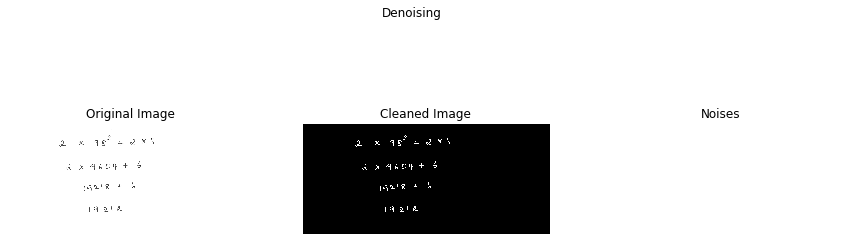

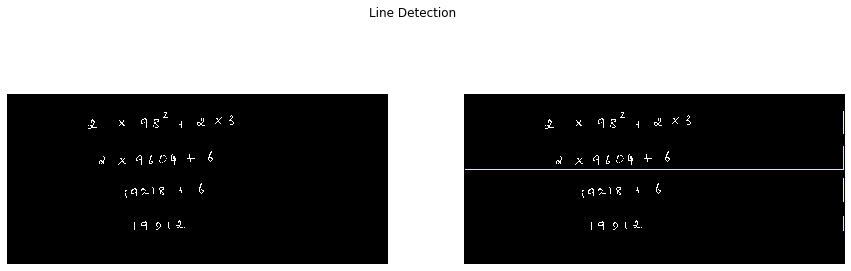

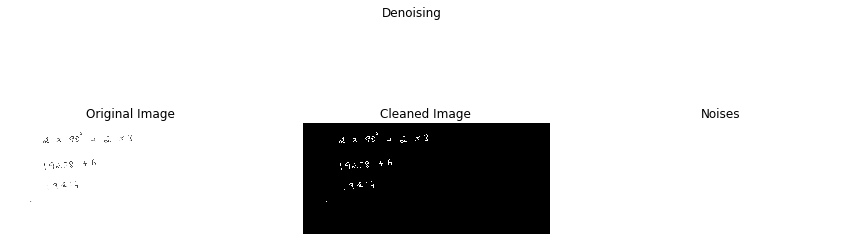

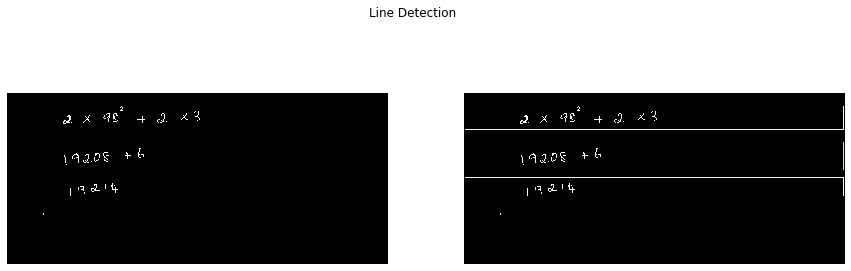

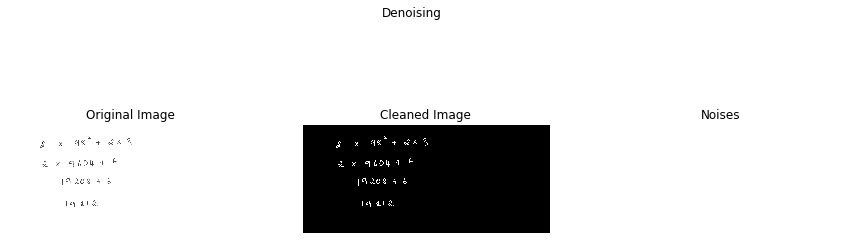

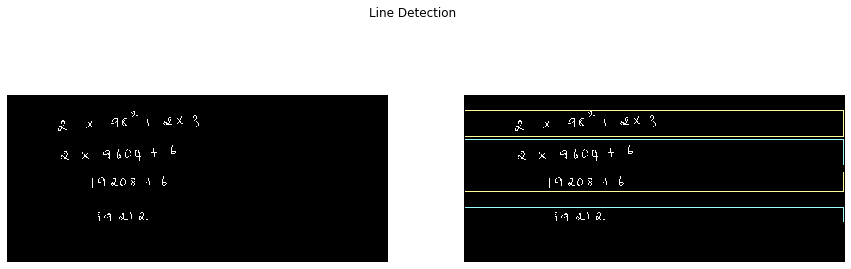

In [36]:
df_lines = pd.DataFrame()
for r , rect in enumerate(main):
    box = img[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
    H,W = box.shape[:2]
    
    cleaned_orig,y1s,y2s = extract_line(box ,show=True)
    
    x1s = [0]*len(y1s)
    x2s = [W]*len(y1s)
    
#        if(len(y1s)-len(y2s) == 0):
#            print('Lines in workspace-%d : %d' %(r, len(y1s)))
    
    df = pd.DataFrame([y1s,y2s,x1s,x2s]).transpose()
    df.columns = ['y1','y2','x1','x2']
    df['box_num'] = r

    df_lines= pd.concat([df_lines, df])

    dict_clean_img.update({r:cleaned_orig})
    dict_img.update({r:box})
    
    #print(df)

df_lines['line_name'] = ['%d%d' %(df_lines.box_num.iloc[i],df_lines.index[i]) \
        for i in range(len(df_lines))]

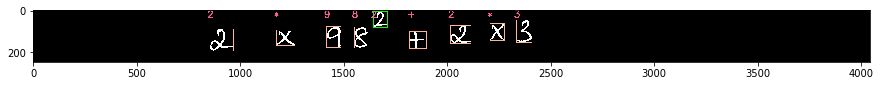

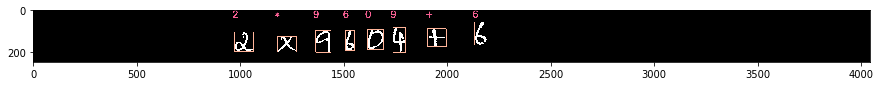

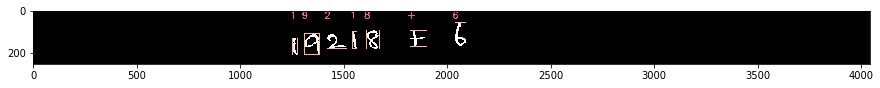

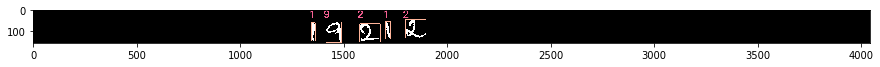

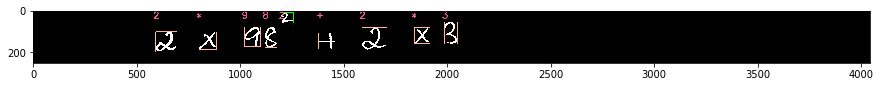

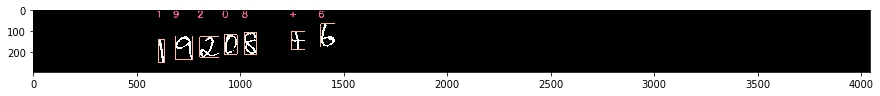

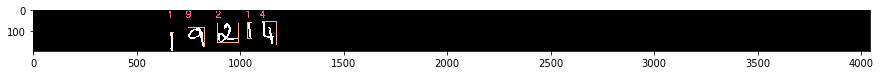

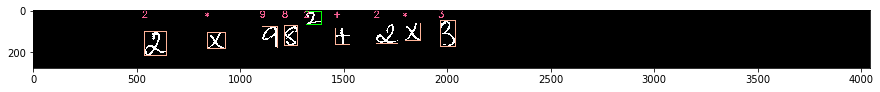

C:\Users\naray\Anaconda3\envs\mirai_1\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\naray\Anaconda3\envs\mirai_1\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


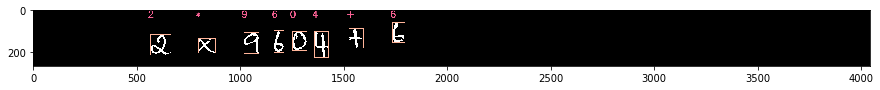

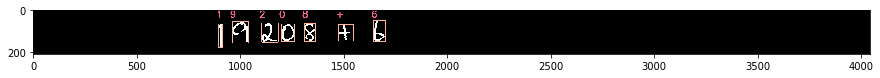

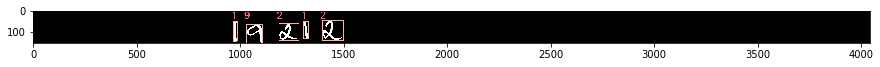

In [37]:
list_chars = list(df_lines.apply(lambda row: text_segment(row['y1'],row['y2'],\
                 row['x1'],row['x2'], row['box_num'],row['line_name'], \
                 show=True), axis=1))

BOX 1
+*2892*3**2
+*2892*3**2 - invalid syntax (<unknown>, line 1)
*2690+96
*2690+96 - invalid syntax (<unknown>, line 1)
1291+86
1291+86
21912
21912
BOX 2
+*2*2893**2
+*2*2893**2 - invalid syntax (<unknown>, line 1)
12908+6
12908+6
19214
19214
BOX 3
*2+982*3**2
*2+982*3**2 - invalid syntax (<unknown>, line 1)
*29046+6
*29046+6 - invalid syntax (<unknown>, line 1)
+018296
+018296 - invalid token (<unknown>, line 1)
92112
92112


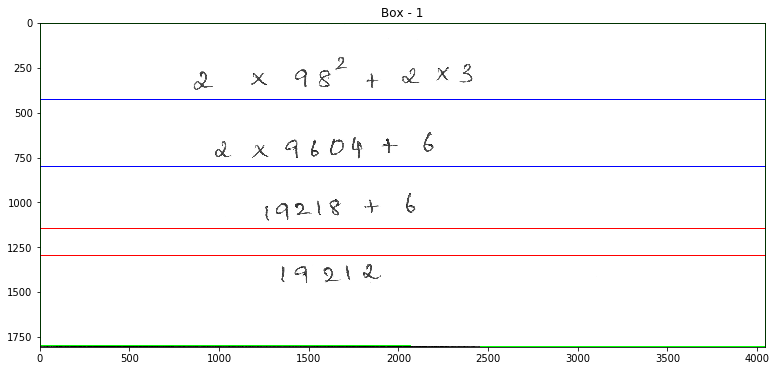

<Figure size 432x288 with 0 Axes>

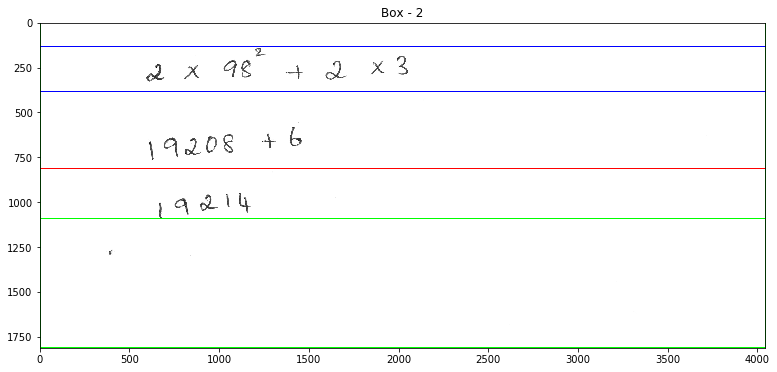

<Figure size 432x288 with 0 Axes>

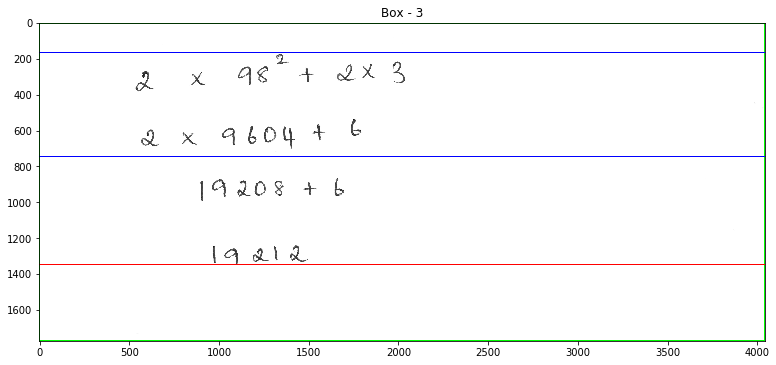

<Figure size 432x288 with 0 Axes>

In [52]:
df_chars = pd.DataFrame(list_chars)
df_chars.columns = ['box_num', 'line_name', 'char_df']
    
box_nums = df_chars.box_num.unique()
char_area_list = []
df_chars['char_df'].apply(lambda d: char_area_list.append(list(d['area'])) )

#Area based threshold for detecting and removing noises
gamma = 0
max_ar = max([max(i) for i in char_area_list])
ar_thresh = max_ar*gamma

#Keeping only those characters whose area of contours is above area threshold
df_chars['char_df'] = df_chars['char_df'].apply(lambda d: d[d.area > ar_thresh] )

for bn in box_nums:
    print('BOX %d' %(bn+1))
    box_img = dict_clean_img[bn] #For Processing B/W image
    box_img_1 = dict_img[bn] #For saving results
    box_img = cv2.cvtColor(box_img, cv2.COLOR_GRAY2BGR)
    
    df = df_chars[df_chars.box_num == bn].copy()
    df_l = df_lines[df_lines["box_num"]==bn].copy() #Defining dF with line info
    
    df['char_df'].apply(lambda d: d.apply(lambda c: cv2.rectangle(box_img, \
      (c['X1'],c['Y1']),(c['X2'], c['Y2']),(255*(c['exp']==1),180,0),2+(2*c['exp'])), axis=1 ) )
    
    df['line_status'] = df['char_df'].apply(lambda d: evaluate(d[["pred","exp","pred_proba"]],A,B,X,Y))
    
    scale_percent = 200 # percent of original size
    width = int(box_img.shape[1] * scale_percent / 100)
    height = int(box_img.shape[0] * scale_percent / 100)
    dim = (width, height)    
    box_img = cv2.resize(box_img, dim, interpolation = cv2.INTER_AREA)

    #Drawing rectangle on original Image
    df_l['line_status'] = list(df['line_status']) 
    df_l.apply(lambda c: cv2.rectangle(box_img_1, (c['x1'],c['y1']),(c['x2'],\
      c['y2']),(255*(c['line_status']==5),255*(c['line_status']==True),\
                                255*(c['line_status']==False)),2), axis=1)
    
    plt.figure(figsize=(13,7))
    plt.title('Box - %d' %(bn+1) )
    plt.imshow(cv2.cvtColor(box_img_1, cv2.COLOR_BGR2RGB))
    plt.figure()

In [39]:
box_nums,df

(array([0, 1, 2], dtype=int64),
     box_num line_name                                            char_df  \
 7         2        20       X1   Y1    X2   Y2   area  exp pred  pred...   
 8         2        21       X1   Y1    X2   Y2  area  exp pred  pred_...   
 9         2        22       X1   Y1    X2   Y2  area  exp pred  pred_...   
 10        2        23       X1    Y1    X2    Y2  area  exp pred  pre...   
 
    line_status  
 7            5  
 8            5  
 9            5  
 10       False  )

In [40]:

k = pd.DataFrame(list_chars)
type(list_chars[2])

list

In [53]:
list_chars

[[0,
  '00',
       X1   Y1    X2   Y2   area  exp pred  pred_proba line_name  box_num
  0  1817  278  1903  363   6806    0    +    0.999892        00        0
  1  1174  272  1266  348   6497    0    *    0.999353        00        0
  2   852  267   970  375  12075    0    2    0.999987        00        0
  3  1550  258  1624  360   7029    0    8    0.999546        00        0
  4  1416  254  1489  358   7070    0    9    0.999967        00        0
  5  2015  249  2117  339   8613    0    2    0.999956        00        0
  6  2205  242  2279  324   5609    0    *    0.999962        00        0
  7  2333  224  2412  334   8132    0    3    0.999462        00        0
  8  1642  184  1713  263   5168    1    2    0.999959        00        0],
 [0,
  '01',
       X1   Y1    X2   Y2  area  exp pred  pred_proba line_name  box_num
  0  1178  674  1275  753  7144    0    *    0.934607        01        0
  1   972  654  1065  751  8460    0    2    0.999983        01        0
  2  1506  64

In [41]:
df_chars

,box_num,line_name,char_df
0,0,00,X1 Y1 X2 Y2 area exp pred pred...
1,0,01,X1 Y1 X2 Y2 area exp pred pred_...
2,0,02,X1 Y1 X2 Y2 area exp pred pre...
3,0,03,X1 Y1 X2 Y2 area exp pred pre...
4,1,10,X1 Y1 X2 Y2 area exp pred pred...
5,1,11,X1 Y1 X2 Y2 area exp pred pred_...
6,1,12,X1 Y1 X2 Y2 area exp pred pre...
7,2,20,X1 Y1 X2 Y2 area exp pred pred...
8,2,21,X1 Y1 X2 Y2 area exp pred pred_...
9,2,22,X1 Y1 X2 Y2 area exp pred pred_...


In [46]:
df_chars['char_df'].values

array([     X1   Y1    X2   Y2   area  exp pred  pred_proba line_name  box_num
0  1817  278  1903  363   6806    0    +    0.999892        00        0
1  1174  272  1266  348   6497    0    *    0.999353        00        0
2   852  267   970  375  12075    0    2    0.999987        00        0
3  1550  258  1624  360   7029    0    8    0.999546        00        0
4  1416  254  1489  358   7070    0    9    0.999967        00        0
5  2015  249  2117  339   8613    0    2    0.999956        00        0
6  2205  242  2279  324   5609    0    *    0.999962        00        0
7  2333  224  2412  334   8132    0    3    0.999462        00        0
8  1642  184  1713  263   5168    1    2    0.999959        00        0,
            X1   Y1    X2   Y2  area  exp pred  pred_proba line_name  box_num
0  1178  674  1275  753  7144    0    *    0.934607        01        0
1   972  654  1065  751  8460    0    2    0.999983        01        0
2  1506  647  1555  746  4416    0    6    0.973627 

In [47]:
df['line_status']

7         5
8         5
9         5
10    False
Name: line_status, dtype: object